In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 生成螺旋线数据
t = np.linspace(0, 4 * np.pi, 100)
x = np.cos(t)
y = np.sin(t)
z = t

x = x*np.random.rand(100)
y = y*np.random.rand(100)

vessel_trajectory = np.stack((x, y, z), axis=-1)
print (vessel_trajectory.shape)


(100, 3)



Square Root Velocity Representation:
(99, 3)


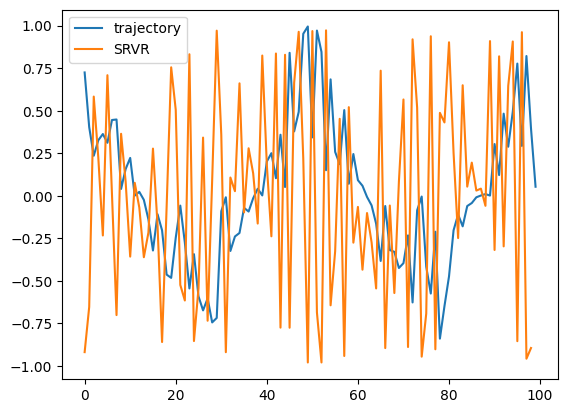

In [11]:

def square_root_velocity(trajectory):
    velocity = np.diff(trajectory, axis=0)
    velocity_magnitude =np.linalg.norm(velocity, axis=-1)
    for i in range(len(velocity)):
        # print (velocity[i])
        velocity[i,0]=velocity[i,0]/velocity_magnitude[i]
        velocity[i,1]=velocity[i,1]/velocity_magnitude[i]
        velocity[i,2]=velocity[i,1]/velocity_magnitude[i]
    return velocity


# 计算平方根速度表示
sr_velocity = square_root_velocity(vessel_trajectory)

print("\nSquare Root Velocity Representation:")
print(sr_velocity.shape)

plt.plot(vessel_trajectory[:,0],label="trajectory")
plt.plot(sr_velocity[:,0],label="SRVR")
plt.legend()

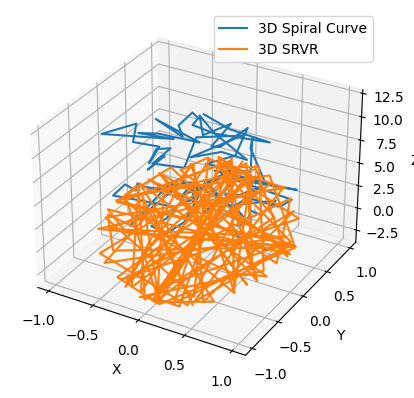

In [12]:
# 创建3D图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制3D曲线
ax.plot(vessel_trajectory[:,0], 
        vessel_trajectory[:,1], 
        vessel_trajectory[:,2], 
        label='3D Spiral Curve')
ax.plot(sr_velocity[:,0], sr_velocity[:,1], sr_velocity[:,2],label='3D SRVR')
# 设置轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图例
ax.legend()

# 显示图形

104
102


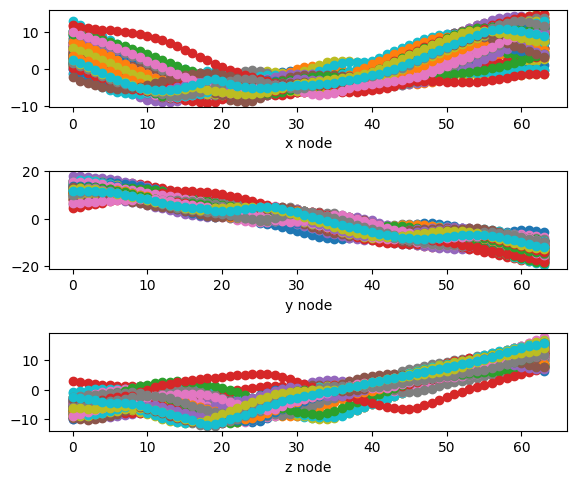

In [13]:
import numpy as np 
import glob
from myvtk.GetMakeVtk import GetMyVtk, makeVtkFile, measure_length
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont
import cv2

files = (glob.glob(".\\scaling\\resamp_attr_ascii\\*.vtk"))
print (len(files))
files.pop(1)
files.pop(34)
print (len(files))

#########################################
#    vmtkで計算したcurv, torsを使う      #
#       0.5mmまでresamplingした         # 
#########################################
# files = (glob.glob(".\\scaling\\resamp_attr_ascii\\vmtkgeometry\\*.vtk"))


r = []
pts = []
PTN = []
curvs = []
torss = []
abscs = [] 
for i in range(len(files)): 
    pt, Curv, Tors, Radius, Abscissas, ptns = GetMyVtk(files[i])
    if len(pt) != 64:
        print (len(pt), files[i])
        continue
    centroid = np.array([np.mean(pt[:,0]),np.mean(pt[:,1]),np.mean(pt[:,2])])
    pt = pt-centroid
    pts.append(pt)
    r.append(Radius)
    PTN.append(ptns)
    curvs.append(Curv)
    torss.append(Tors)
    abscs.append(Abscissas)
pts = np.array(pts)
r = np.array(r)
PTN = np.array(PTN)
curvs=np.array(curvs)
torss = np.array(torss)
abscs= np.array(abscs)

fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.scatter(range(len(pts[i])), pts[i,:,0])
    ax2.scatter(range(len(pts[i])), pts[i,:,1])
    ax3.scatter(range(len(pts[i])), pts[i,:,2])


In [14]:
print (pts.shape)

sr_pts = []
for vessel_trajectory in pts:
    sr_velocity = square_root_velocity(vessel_trajectory)
    sr_pts.append(sr_velocity)

sr_pts = np.array(sr_pts)
print (sr_pts.shape)

mean_sr = np.mean(sr_pts,axis=0)
print (mean_sr.shape)

(102, 64, 3)
(102, 63, 3)
(63, 3)


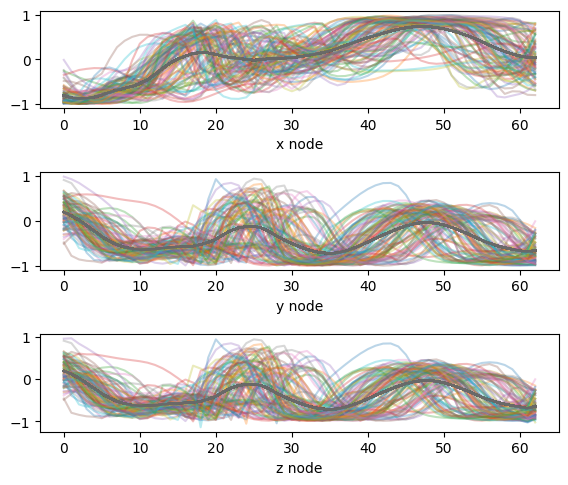

In [15]:
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.plot(range(len(sr_pts[i])), sr_pts[i,:,0],alpha=0.3)
    ax1.plot(range(len(mean_sr)), mean_sr[:,0],c="dimgray")
    ax2.plot(range(len(sr_pts[i])), sr_pts[i,:,1],alpha=0.3)
    ax2.plot(range(len(mean_sr)), mean_sr[:,1],c="dimgray")
    ax3.plot(range(len(sr_pts[i])), sr_pts[i,:,2],alpha=0.3)
    ax3.plot(range(len(mean_sr)), mean_sr[:,2],c="dimgray")


Optimize the wrap function.

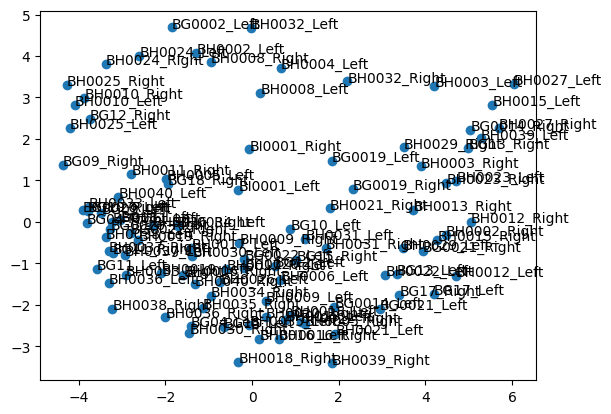

In [16]:
from sklearn.decomposition import PCA

quad_sr = []
for i in range(len(sr_pts)):
    quad_sr.append(sr_pts[i].flatten())
quad_sr = np.array(quad_sr)


pca = PCA(n_components=10)
result = pca.fit_transform(quad_sr)


plt.scatter(result[:,0],result[:,1])

for i in range(len(sr_pts)):
    plt.text(result[i, 0],result[i, 1],files[i].split("\\")[-1].split(".")[0])

n_neighbors参数的选取需要在过拟合和欠拟合之间找到平衡。选择较小的邻居数可能会导致过拟合，降维后的数据可能无法准确地捕捉原始数据中的全局结构。相反，选择较大的邻居数可能会导致欠拟合，因为局部线性关系可能无法准确地描述数据的全局结构。

In [53]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import train_test_split

# 设置Tangent PCA参数
err = []
rg = range(3,25)
n_components = 3

for n_neighbors in rg:

    err_in_n = []
    for i in range(100):
        quad_sr_train,quad_sr_valid = train_test_split(quad_sr, test_size=0.1, random_state=i) 

        # 应用Tangent PCA进行降维
        tangent_pca = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method='ltsa')
        X_tangent_pca = tangent_pca.fit_transform(quad_sr_train)

        from sklearn.metrics import mean_squared_error
        from sklearn.linear_model import LinearRegression

        linear_regression = LinearRegression(fit_intercept=False)
        linear_regression.fit(X_tangent_pca, quad_sr_train)

        # 重构数据
        data_reconstructed = linear_regression.predict(X_tangent_pca)

        reconstruction_error = mean_squared_error(quad_sr_train, data_reconstructed)

        err_in_n.append(reconstruction_error)
    err.append(err_in_n)

        # print("n_neighbors:",n_neighbors,"Reconstruction error:", reconstruction_error)
#plt.plot(rg, err, marker="x")
#for i in range(len(rg)):
#    plt.text(rg[i], err[i], rg[i])




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


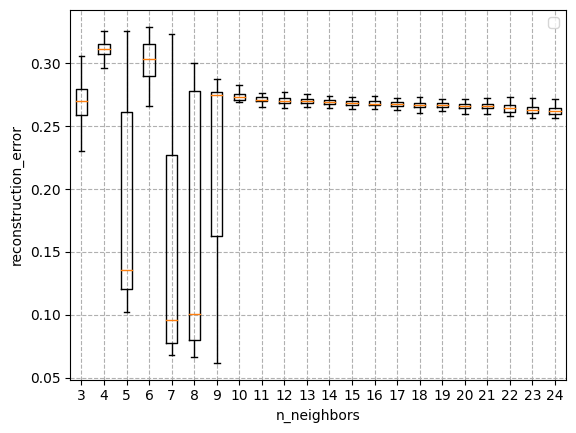

In [54]:
err = np.array(err)
plt.grid(linestyle="--")
plt.boxplot(err.T, positions=rg, showfliers=False)
plt.xlabel("n_neighbors")
plt.ylabel("reconstruction_error")
plt.legend()

n_neighbors: 11 Reconstruction error: 0.2750452807448463


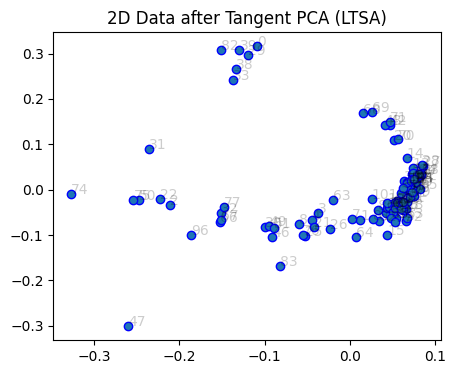

In [111]:
n_components = 2
n_neighbors = 10

tangent_pca = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method='ltsa')
X_tangent_pca = tangent_pca.fit_transform(quad_sr)


linear_regression = LinearRegression(fit_intercept=False)
linear_regression.fit(X_tangent_pca, quad_sr)

data_reconstructed = linear_regression.predict(X_tangent_pca)
print("n_neighbors:",n_neighbors,"Reconstruction error:", reconstruction_error)

# 可视化降维后的数据集
plt.figure(figsize=(5, 4))
plt.scatter(X_tangent_pca[:, 0], X_tangent_pca[:, 1],edgecolors="blue")
for i in range(len(X_tangent_pca)):
    plt.text(X_tangent_pca[i, 0], X_tangent_pca[i, 1],i,alpha=0.2)



plt.title('2D Data after Tangent PCA (LTSA)')
plt.show()



In [103]:
for i in range(len(X_tangent_pca)):
    if abs(X_tangent_pca[i,0])<0.1:
        print (X_tangent_pca[i],)

[ 0.01223598 -0.06641852]
[-0.03779907 -0.05193861]
[-0.04485178 -0.06709668]
[0.07305919 0.03481802]
[0.07452955 0.0210099 ]
[ 0.00204548 -0.06511678]
[-0.05960746 -0.07551278]
[ 0.049294   -0.03597851]
[0.06802643 0.01573731]
[ 0.06703964 -0.02726223]
[0.07508965 0.03391598]
[0.07350034 0.04803742]
[0.06672055 0.06946378]
[ 0.04373739 -0.10000812]
[0.07432074 0.03753309]
[0.08301559 0.03211015]
[0.08368797 0.03485056]
[ 0.04649421 -0.03873203]
[0.05127235 0.11027795]
[-0.04261583 -0.08238667]
[ 0.06613142 -0.04329254]
[ 0.04233446 -0.0516101 ]
[-0.05305881 -0.10294795]
[-0.02367926 -0.08647584]
[0.08586271 0.05225853]
[0.08435788 0.05511051]
[-0.09924015 -0.08309453]
[0.06334269 0.01890018]
[ 0.049513   -0.06301235]
[ 0.04325767 -0.04134868]
[ 0.07024784 -0.00475472]
[ 0.04826365 -0.03835912]
[ 0.04594325 -0.03872804]
[0.04640044 0.14351367]
[0.0405889  0.14314705]
[0.0773222  0.01764755]
[0.07237376 0.02450906]
[-0.09158709 -0.10444303]
[ 0.05445703 -0.06203087]
[-0.09500279 -0.0797

In [ ]:
X